# 样式迁移

喜欢拍照的同学可能都接触过滤镜，它们能改变照片的颜色风格，使得风景照更加锐利，或者人像更加美白。但一个滤镜通常只能改变照片的某个方面，要达到想要的风格，经常需要我们大量组合尝试多个滤镜。这个过程被通常称之为“PS一下”。对于简单的调整，例如拉一拉颜色曲线变成日系小清新风或者加点德味，通常都不难做到。但对于复杂的要求，例如将图片调成梵高风，则需要大量的专业技巧。例如17年上映的[《挚爱梵高》](http://lovingvincent.com)由115名专业画师画了65,000张梵高风格的油画而得。

一个自然的想法是，我们能不能通过神经网络来自动化这个过程。具体来说，我们希望将一张指定的图片的风格，例如梵高的某张油画，应用到另外一张内容图片上。

![Neural Style](../img/neural-style.svg)

[Gatys等人](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)开创性的通过匹配卷积神经网络的中间层输出来训练出合成图片。它的流程如下所示：

![Neural Style Training](../img/neural-style2.svg)

1. 我们首先挑选一个卷积神经网络来提取特征。我们选择它的特定层来匹配样式，特定层来匹配内容。示意图中我们选择层1,2,4作为样式层，层3作为内容层。
1. 输入样式图片并保存样式层输出，记第 $i$ 层输出为 $s_i$
1. 输入内容图片并保存内容层输出，记第 $i$ 层输出为 $c_i$
1. 初始化合成图片 $x$ 为随机值或者其他更好的初始值。然后进行迭代使得用 $x$ 抽取的特征能够匹配上 $s_i$ 和 $c_i$。具体来说，我们如下迭代直到收敛。
  1. 输入 $x$ 计算样式层和内容层输出，记第 $i$ 层输出为 $y_i$
  1. 使用样式损失函数来计算 $y_i$ 和 $s_i$ 的差异
  1. 使用内容损失函数来计算 $y_i$ 和 $c_i$ 的差异
  1. 对损失求和并对输入 $x$ 求导，记导数为 $g$
  1. 更新 $x$， 例如 $x = x - \eta g$


内容损失函数使用通常回归用的均方误差。对于样式，我们可以将它看成是像素点在每个通道的统计分布。例如要匹配两张图片的颜色，我们的一个做法是匹配这两张图片在RGB这三个通道上的直方图。更一般的，假设卷积层的输出格式是$c \times h \times w$，既`channels x height x width`。那么我们可以把它变形成 $c \times hw$ 的2D数组，并将它看成是一个维度为$c$ 的随机变量采样到的 $hw$ 个点。所谓的样式匹配就是使得两个 $c$ 维随机变量统计分布一致。

匹配统计分布常用的做法是冲量匹配，就是说使得他们有一样的均值，协方差，和其他高维的冲量。为了计算简单起见，我们这里假设卷积输出已经是均值为0了，而且我们只匹配协方差。也就是说，样式损失函数就是对 $s_i$ 和 $y_i$ 计算 Gram 矩阵然后应用均方误差

$$ \textrm{styleloss}(s_i, y_i) = \frac{1}{c^2hw} \| s_i s_i^T - y_i y_i^T \|_F $$

这里假设我们已经将 $s_i$ 和 $y_i$ 变形成了 $c \times hw$ 的2D矩阵了。

下面我们将实现这个算法来深入理解各个参数，例如样式层和内容层的选取，对实际结果的影响。

## 数据

我们将尝试将下面的[水粉橡树](https://spirosart.deviantart.com/art/Autumn-oak-591768233)的样式应用到[实拍的松树](http://imgstocks.com/forest-path-forest-path-tree-pine-tree-summer.html)上。


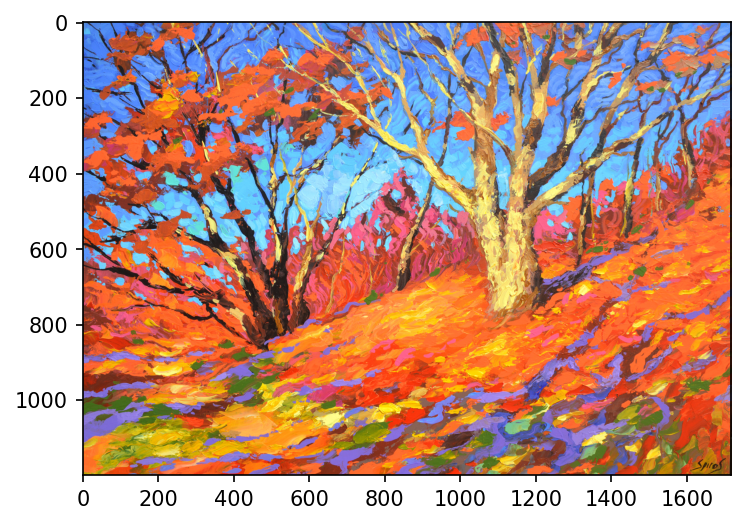

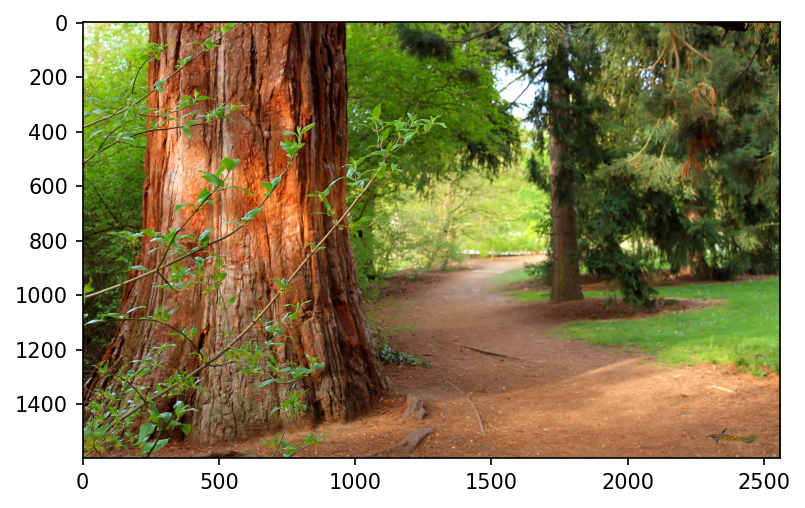

In [1]:

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import matplotlib.pyplot as plt

from mxnet import image

style_img = image.imread('../img/autumn_oak.jpg')
content_img = image.imread('../img/pine-tree.jpg')

plt.imshow(style_img.asnumpy())
plt.show()
plt.imshow(content_img.asnumpy())
plt.show()

跟前面教程一样我们定义预处理和后处理函数，它们将原始图片进行归一化并转换成卷积网络接受的输入格式，和还原成能展示的图片格式。


In [2]:
# from mxnet import nd 

# rgb_mean=nd.array([0.485,0.456,0.406]) 
# rgb_std=nd.array([0.229,0.224,0.225]) 
# def preprocess(img,image_shape):
#     img=image.imresize(img,*image_shape) 
#     img=(img.astype('float32')/255-rgb_mean)/rgb_std
#     return img.transpose((2,0,1)).expand_dims(axis=0) 

# def postprocess(img):
#     img=img[0].as_in_context(rgb_std.context) 
#     return (img.transpose((1,2,0))*rgb_std+rgb_mean).clip(0,1)

In [3]:
from mxnet import nd

rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32')/255 - rgb_mean) / rgb_std
    return img.transpose((2,0,1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1,2,0))*rgb_std + rgb_mean).clip(0,1)

# 模型
我们使用原论文使用的VGG 19模型。并下载在Imagenet上训练好的权重 

In [4]:
from mxnet.gluon.model_zoo import vision as models 
pretrained_net=models.vgg19(pretrained=True) 
pretrained_net 

VGG(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

回忆[VGG](../chapter_convolutional-neural-networks/vgg-gluon.md)这一章里，我们使用五个卷积块`vgg_block`来构建网络。快之间使用`nn.MaxPool2D`来做间隔。我们有很多种选择来使用某些层作为样式和内容的匹配层。通常越靠近输入层越容易匹配内容和样式的细节信息，越靠近输出则越倾向于语义的内容和全局的样式。这里我们按照原论文使用每个卷积块的第一个卷基层输出来匹配样式，和第四个块中的最后一个卷积层来匹配内容。根据`pretrained_net`的输出我们记录下这些层对应的位置。


In [5]:
style_layers=[0,5,10,19,28] 
content_layers=[25]

因为只需要使用中间层的输出，我们构建一个新的网络，它只保留我们需要的层 

In [6]:
from mxnet.gluon import nn 
def get_net(pretrained_net,content_layers,style_layers):
    net=nn.Sequential() 
    for i in range(max(content_layers+style_layers)+1):
        net.add(pretrained_net.features[i]) 
    return net 

net=get_net(pretrained_net,content_layers,style_layers) 
net

Sequential(
  (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Activation(relu)
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Activation(relu)
  (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Activation(relu)
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Activation(relu)
  (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Activation(relu)
  (16): Conv2D(256 -> 256, kern

In [7]:
def extract_features(x,content_layers,style_layers):
    contents=[]
    styles=[] 
    for i in range(len(net)):
        x=net[i](x) 
        if i in style_layers:
            styles.append(x)
        if i in content_layers:
            contents.append(x) 
    return contents,styles 

# 损失函数
内容匹配是一个典型的回归问题我们将来使用均方误差来比较内容层的输出。

In [8]:
def content_loss(yhat,y):
    return (yhat-y).square().mean() 

样式匹配则是通过拟合Gram矩阵。我们先定义它的计算： 

In [9]:
def gram(x):
    c=x.shape[1]
    n=x.size / x.shape[1]
    y=x.reshape((c,int(n))) 
    return nd.dot(y,y.T)/n
x=nd.ones((1,3,4,4)) 
gram(x) 


[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
<NDArray 3x3 @cpu(0)>

In [10]:
c=x.shape[1]
print(c)
n=x.size/x.shape[1]
print(n)
y=x.reshape((c,int(n))) 
print(y) 

print(nd.dot(y,y.T)/n)

3
16.0

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
<NDArray 3x16 @cpu(0)>

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
<NDArray 3x3 @cpu(0)>


和对应的损失函数。对于要匹配的样式图片它的样式输出在训练中不会改变，我们将提前计算好它的Gram矩阵来作为输出使得计算加速。

In [11]:
def style_loss(yhat,gram_y):
    return (gram(yhat)-gram_y).square().mean() 

当使用靠近输出层的高层输出来拟合时，经常可以观察到学到的图片里面有大量高频的噪音。这个优点类似于老式天线电视机经常遇到的白噪音。有很多方法降噪，例如可以加入模糊滤镜，或者使用总变差降噪（Total Variation Denosiing) . 

In [12]:
def tv_loss(yhat):
    return 0.5*((yhat[:,:,1:,:]-yhat[:,:,:-1,:]).abs().mean()+
               (yhat[:,:,:,1:]-yhat[:,:,:,:-1]).abs().mean()) 

总损失函数就是上述的三个损失函数的加权和。通过调整权重值我们可以控制学到的图片是否保留更多样式，更多内容，还是更加干净。注意到样式匹配中我们使用了5个层的输出，我们对靠近输入的层给予比较大的权重。

In [13]:
channels=[net[l].weight.shape[0] for l in style_layers]
style_weights=[1e4/n**2 for n in channels]

content_weights=[1] 
tv_weight=10 


我们可以使用nd.add_n 来将多个损失函数的输出按权重加起来 。 

In [14]:
def sum_loss(loss,preds,truths,weights):
    return nd.add_n(*[w*loss(yhat,y) for w,yhat,y in zip(weights,preds,truths)]) 

# 训练 
我们首先定义两个函数，他们分别对源内容图片和源样式图片提取特征。 

In [15]:
def get_contents(image_shape):
    content_x = preprocess(content_img, image_shape).copyto(ctx)
    content_y, _ = extract_features(content_x, content_layers, style_layers)
    return content_x, content_y

def get_styles(image_shape):
    style_x = preprocess(style_img, image_shape).copyto(ctx)
    _, style_y = extract_features(style_x, content_layers, style_layers)
    style_y = [gram(y) for y in style_y]
    return style_x, style_y

In [16]:
from time import time 
from mxnet import autograd 

def train(x,max_epochs,lr,lr_decay_epoch=200):
    tic=time() 
    for i in range(max_epochs):
        with autograd.record():
            content_py,style_py=extract_features(
                x,content_layers,style_layers) 
            content_L=sum_loss(
                content_loss,content_py,content_y,content_weights) 
            style_L=sum_loss(style_loss,style_py,style_y,style_weights)
            tv_L=tv_weight*tv_loss(x)
            loss=style_L+content_L+tv_L 
        loss.backward() 
        x.grad[:]/=x.grad.abs().mean()+1e-8
        x[:]-=lr*x.grad 
        nd.waitall() 
        if i and i%20==0:
            print('Batch %3d,content %2.f,style %.2f, TV %.2f, time %.1f sec'%(
                i,content_L.asscalar(),style_L.asscalar(),tv_L.asscalar(),time()-tic)) 
            tic=time()
        if i and i % lr_decay_epoch ==0:
            lr*=0.1 
            print('change lr to ',lr) 
    plt.imshow(postprocess(x).asnumpy()) 
    plt.show() 
    return x 


训练过程跟之前的主要的主要不同在于

1. 这里我们的损失函数更加复杂。
1. 我们只对输入进行更新，这个意味着我们需要对输入`x`预先分配了梯度。
1. 我们可能会替换匹配内容和样式的层，和调整他们之间的权重，来得到不同风格的输出。这里我们对梯度做了一般化，使得不同参数下的学习率不需要太大变化。
1. 仍然使用简单的梯度下降，但每*n*次迭代我们会减小一次学习率


aaaaaaaa
Batch  20,content 28,style 430.27, TV 4.75, time 4.8 sec
Batch  40,content 28,style 236.12, TV 5.09, time 0.4 sec
Batch  60,content 30,style 163.18, TV 5.26, time 0.4 sec
Batch  80,content 27,style 140.35, TV 5.32, time 0.4 sec
Batch 100,content 26,style 127.84, TV 5.43, time 0.4 sec
Batch 120,content 26,style 118.18, TV 5.49, time 0.4 sec
Batch 140,content 26,style 109.54, TV 5.53, time 0.4 sec
Batch 160,content 27,style 101.11, TV 5.58, time 0.4 sec
Batch 180,content 26,style 116.26, TV 5.57, time 0.4 sec
Batch 200,content 24,style 114.57, TV 5.64, time 0.4 sec
change lr to  0.010000000000000002
Batch 220,content 20,style 25.59, TV 5.39, time 0.4 sec
Batch 240,content 19,style 21.48, TV 5.36, time 0.4 sec
Batch 260,content 17,style 19.87, TV 5.32, time 0.4 sec
Batch 280,content 17,style 18.06, TV 5.29, time 0.4 sec
Batch 300,content 16,style 17.26, TV 5.25, time 0.4 sec
Batch 320,content 15,style 16.64, TV 5.23, time 0.4 sec
Batch 340,content 15,style 16.15, TV 5.21, time 0.

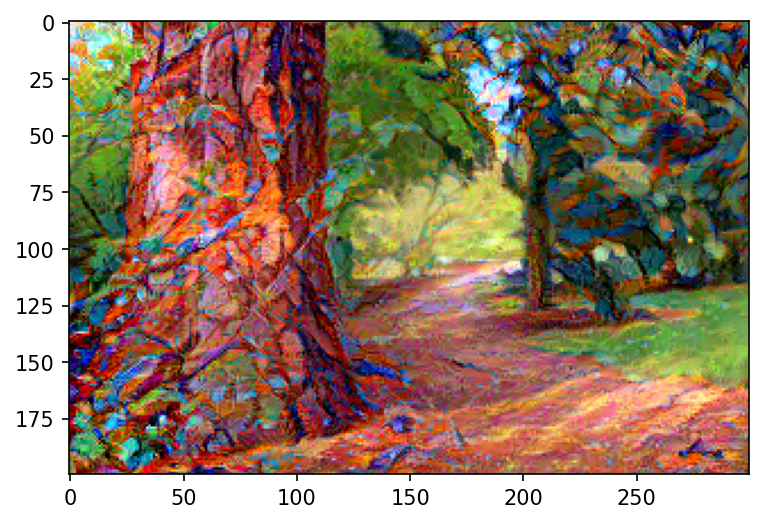

In [17]:
import sys
sys.path.append('..')
import utils

image_shape = (300,200)

ctx = utils.try_gpu()
net.collect_params().reset_ctx(ctx)

content_x, content_y = get_contents(image_shape)
style_x, style_y = get_styles(image_shape)

x = content_x.copyto(ctx)
x.attach_grad()

y = train(x, 500, 0.1)


观察损失值的变化。因为我们使用了内容图片作为初始化，所以一开始看到样式损失比较大。但随着迭代的进行，它减少的非常迅速，尤其是在每次调整学习率后。噪音在训练中有略微的增加，但在后期还是控制在合理的范围。

最后的结果里可以看到明显的我们将样式图片里面的大的色块应用到了内容图片上。但是由于输入图片大小比较小，所以看到细节上比较模糊。

下面我们在更大的`1200 x 800`的尺寸上训练，希望能得到更加清晰的合成图片。同样为了加速收敛，我们将前面得到的合成图片放大成我们要的尺寸做为初始值。


In [18]:
# image_shape=(1200,800) 
# content_x,content_y=get_contents(image_shape) 
# style_x,style_y=get_styles(image_shape) 
# x=preprocess(postprocess(y)*255,image_shape).copyto(ctx)
# x.attach_grad() 
# z=train(x,300,0.1,100) 


Batch  20,content 58,style 398.39, TV 3.21, time 6.4 sec
Batch  40,content 55,style 418.77, TV 3.48, time 3.6 sec
Batch  60,content 55,style 448.55, TV 3.65, time 3.6 sec
Batch  80,content 53,style 462.18, TV 3.76, time 3.6 sec
Batch 100,content 53,style 477.27, TV 3.85, time 3.7 sec
change lr to  0.010000000000000002
Batch 120,content 29,style 38.07, TV 3.33, time 3.7 sec
Batch 140,content 26,style 22.15, TV 3.13, time 3.7 sec
Batch 160,content 22,style 22.36, TV 3.02, time 3.7 sec
Batch 180,content 21,style 22.57, TV 2.95, time 3.7 sec
Batch 200,content 21,style 19.96, TV 2.90, time 3.7 sec
change lr to  0.0010000000000000002
Batch 220,content 19,style 9.99, TV 2.86, time 3.7 sec
Batch 240,content 18,style 9.37, TV 2.84, time 3.7 sec
Batch 260,content 18,style 8.94, TV 2.82, time 3.7 sec
Batch 280,content 17,style 8.61, TV 2.80, time 3.7 sec


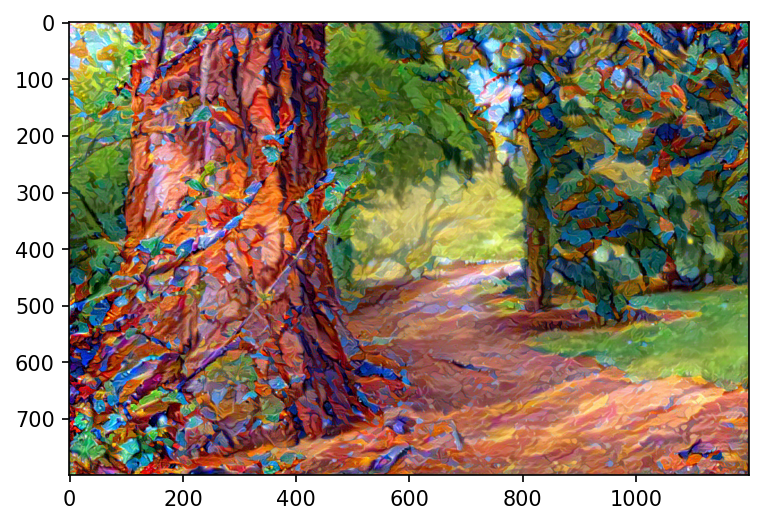

In [19]:
image_shape = (1200,800)

content_x, content_y = get_contents(image_shape)
style_x, style_y = get_styles(image_shape)

x = preprocess(postprocess(y)*255, image_shape).copyto(ctx)
x.attach_grad()

z = train(x, 300, 0.1, 100)


可以看到由于初始值更加好，这次的收敛更加迅速，虽然每次迭代花时间更长。由于是图片更大，我们可以更清楚的看到细节。里面不仅有大块的色彩，色彩块里面也有细微的纹理。这是由于我们在匹配样式的时候使用了多层的输出。

最后我们可以把合成的图片保存下来。


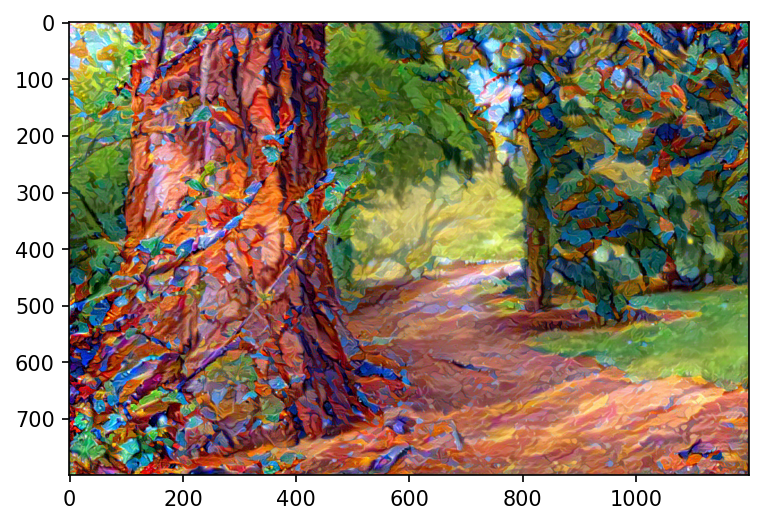

In [22]:
plt.imsave('result.png', postprocess(z).asnumpy())
plt.imshow(postprocess(z).asnumpy())
plt.show()


## 总结

通过匹配神经网络的中间层输出，我们可以有效的融合不同图片的内容和样式。

## 练习

1. 改变内容和样式层
1. 使用不同的权重
1. 换几张样式和内容图片


**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/3273)
